# Project Info

This is the main notebook to design the DnD Dungeon Master

Specification from Canvas:

Project Requirements

World Memory: Implement persistent storage of state for each location. The AI must recognize when players revisit a location and present an updated description reflecting prior actions.

Map Generation and Navigation: The AI should create and maintain a coherent map of connected locations, ensuring logical placement and connections.

Dynamic Descriptions and Interactions: Generate unique descriptions and manage NPC or item states dynamically, adapting based on player actions.
Randomized Location Descriptions and Encounters: When players enter a new location, the AI generates a fresh, random description consistent with nearby areas and may spawn new NPCs or items. This allows each exploration to feel novel and immersive while maintaining a coherent world.

Simplified D&D Mechanics: Use a streamlined set of D&D-inspired mechanics (detailed below) to guide the AI’s decisions and narration for combat, exploration, and interactions.

DnD Simplified Mechanics:

NPC Interaction and Combat
NPCs have two attributes: Health Points (HP) and Attack Power.
Combat: When players engage in combat, each side rolls a virtual 1d6 (a six-sided die) and adds it to their Attack Power to determine damage for that turn.

Victory Conditions: The player wins if the NPC’s HP reaches zero, and loses if their own HP does.
Skill Checks and Random Outcomes
When players attempt a risky action (e.g., unlocking a door), the AI rolls a 1d10 (a ten-sided die) for a skill check.
For simple tasks, a roll of 3 or higher succeeds.
For challenging tasks, a roll of 6 or higher is needed.
Descriptions should vary based on success or failure, giving the interaction a creative touch.

Inventory and Simple Item Use
Players can pick up and use basic items like keys or healing potions.
Items: Each item has a single effect—e.g., a potion heals 10 HP, a key unlocks a specific door.
The AI remembers which items have been used or taken to manage inventory without complex tracking.

Experience Points and Leveling (Optional)
Players can gain Experience Points (XP) for completing significant actions or defeating NPCs.
When players reach 50 XP, they "level up," gaining a small HP increase.
This provides a sense of progression with minimal complexity.

State Persistence

The AI must track and remember states for each location and NPC to maintain continuity. This includes:

Location State: Track if a door is unlocked, a chest is opened, or an item has been taken.

NPC Status: Remember if NPCs have been defeated, moved, or interacted with.

Inventory: Track items players possess and mark items as “used” once they’re applied (e.g., a used key).

Player Stats: Keep player attributes like HP, XP, and inventory status persistent across moves.


Map Representation

The map is a logical grid or node-based structure, where each “node” represents a unique location.

Location Connections: Each node includes connections to adjacent locations (e.g., north, south, east, west).

Unique Descriptions and Random Encounters: Each time players enter a new node, the AI generates a fresh description that is contextually consistent with nearby areas. The AI may also spawn random NPCs or items, creating an immersive experience while ensuring coherence.

NPC and Item Placement: Each node may contain NPCs or items, which the AI can add or remove based on player actions.

GRADUATE STUDENT:
Graduate students are required to implement additional features to expand the AI’s storytelling capabilities:

Text-to-Speech (TTS): Add a TTS system to narrate the AI-generated descriptions and interactions, enhancing the immersive experience.

Image Generation: Integrate a simple image generation model to create visual representations of locations or key events, adding a visual storytelling element to the text-based game.

# Keys and Libraries

Loading all relevant keys:

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

assert 'OPENAI_API_KEY' in os.environ, "You will need to set an OPENAI_API_KEY"
#assert 'LANGCHAIN_API_KEY' in os.environ, "You will need to set an LANGCHAIN_API_KEY"

Importing all relevant libraries:

In [3]:
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.chains import LLMMathChain
from langchain.prompts import PromptTemplate
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_core.messages import AIMessage, HumanMessage

from IPython.display import clear_output # FOR CLEAN OUTPUTS ON NOTEBOOK

from openai import OpenAI # FOR TTS

import random
import numpy as np
import json

# Player Class

In [ ]:
class Player:
    def __init__(self, name, max_hp, xp, level):
        self.name = name
        self.max_hp = max_hp
        self.hp = max_hp
        self.xp = xp
        self.level = level
        self.inventory = []

    def take_damage(self, damage):
        self.hp -= damage
        if self.hp < 0:
            self.hp = 0

    def heal(self, amount):
        if self.has_item("Potion") or self.has_item("Health Potion") or self.has_item("Healing Potion"):
            self.hp = min(self.hp + amount, self.max_hp)
            self.remove_from_inventory("Potion")
            self.remove_from_inventory("Health Potion")
            self.remove_from_inventory("Healing Potion")
        else:
            print("You don't have a healing potion.")

    def gain_xp(self, xp):
        self.xp += xp
        if self.xp >= 50:  # Adjust the XP threshold as needed
            self.level += 1
            self.max_hp += 10  # Increase max HP with each level
            self.xp -= 50

    def add_to_inventory(self, item):
        self.inventory.append(item)

    def remove_from_inventory(self, item):
        if item in self.inventory:
            self.inventory.remove(item)
        else:
            print("Item not in inventory")

    def has_item(self, item):
        return item in self.inventory

# Initialize the player
player = Player("Adventurer", 100, 0, 1)

player.add_to_inventory("Sword")
player.add_to_inventory("Healing Potion")

# Example usage:
# player.take_damage(20)
# print(f"Player's HP: {player.hp}")

# player.heal(30)
# print(f"Player's HP: {player.hp}")

# player.gain_xp(50)
# print(f"Player's level: {player.level}")

# print(f"Player's inventory: {player.inventory}")

# Tools

In [5]:
@tool
def rolld6() -> int:
    """ Roll a six-sided dice
    """
    rand = random.randint(1, 6)
    return rand

@tool
def rolld10() -> int:
    """ Roll a ten-sided dice
    """
    rand = random.randint(1, 10)
    return rand

@tool
def attack(attacker_power: int, defender_health: int, againstPlayer: bool) -> int:
    """ Attacker attacks the defender and check defener health
    args:
        attacker_power: power of the attack from the attacker
        defender_health: health of the defender
    """
    attacker_roll = rolld6({})
    attacker_trueap = attacker_power + attacker_roll
    if againstPlayer:
        player.take_damage(attacker_trueap)
    defender_health -= attacker_trueap
    return defender_health
@tool 
def combat(player_attack: int, player_health:int, npc_attack: int, npc_health: int) -> str:
    """ A combat encounter between a player and a npc
    args:
        player_attack: the attack power of the player
        player_health: the health of the player
        npc_attack: the attack power of the npc
        npc_health: the health of the npc
    Returns:
        a message indicating the result of the encounter
    """
    while (player_health > 0 and npc_health > 0):
        #player attack
        npc_health -= player_attack + random.randint(1,6)
        player_health -= npc_attack + random.randint(1,6)
    if (player_health > 0 and npc_health <= 0 ):
        return(f"The player has defeated the npc and has {player_health} remaining")
    if (npc_health > 0 and player_health <= 0):
        return("The player has been defeated by the npc")
    else:
        return("The player and npc have both killed each other")
@tool
def heal_player():
    """Heals the player by 50 hp.
    Returns:
        A message indicating the result of the healing.
    """
    player.heal(50)

    if player.hp == player.max_hp:
        print(f"{player.name} is fully healed. Current HP: {player.hp}")
        return f"{player.name} is fully healed. Current HP: {player.hp}" 
    else:
        print(f"{player.name} healed 50 HP. Current HP: {player.hp}")
        return f"{player.name} healed 50 HP. Current HP: {player.hp}"

@tool
def add_item(item):
    """Adds an item to the player's inventory
    Args:
        item: the item to be added
    Returns:
        A message stating that the item was added
    """
    player.add_to_inventory(item)
    
@tool
def remove_item(item):
    """Removes an item from the player's inventory
    Args:
        item: the item to be removed
    Returns:
        A message stating that the item was removed
    """
    player.remove_from_inventory(item)

@tool
def move_Room(direction: str) -> str:
    """Moves player across rooms in predefined grid."""

tools = [rolld6, rolld10, attack, combat, heal_player, add_item, remove_item]

# AI Setup

In [6]:
llm = ChatOpenAI(temperature = 0, model='gpt-3.5-turbo-1106')

Prompt Template

In [7]:
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

Use AI Agent

In [8]:
# Create an OpenAI Functions agent
agent = create_openai_functions_agent(llm, tools, prompt=prompt)
# Create an agent executor
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent,tools=tools,verbose=True, max_iteration=50, max_execution_time=50)

# TTS and Image Gen

Second AI agent to operate TTS and Image Gen

Using SimpleAudio to output audio
%pip install simpleaudio

In [ ]:
from openai import OpenAI
import urllib.request 
from PIL import Image 
#import simpleaudio as sa
client = OpenAI()

def GenerateImage(prompt:str):
    response = client.images.generate(
    model="dall-e-3",
    prompt=prompt,
    size="1024x1024",
    quality="standard",
    n=1,
    )
    image_url = response.data[0].url
    urllib.request.urlretrieve(image_url,"surrounding.png") 
    img = Image.open("surrounding.png") 
    display(img)

def TextToSpeech(text:str):
    response = client.audio.speech.create(
        model="tts-1",
        voice="echo", # Best voice in the sample pack
        input=text,
        response_format="wav",
        )
    response.write_to_file("output.wav")
    wave_obj = sa.WaveObject.from_wave_file("output.wav")
    play_obj = wave_obj.play()
    play_obj.wait_done()
    

TypeError: OpenAI.__init__() got an unexpected keyword argument 'verbose'

# Mapping

In [10]:
import numpy as np
import random
#Create an empty map
mapsize = 5
grid = np.empty((mapsize, mapsize), dtype=object)
for i in range(mapsize):
    for j in range(mapsize):
        grid[i, j] = {"Description": "Unknown", "NPCs": [], "Items": [], "Doors": [], "Chests": []}
#Select a random starting position
currentLocation = [random.randint(0, mapsize-1), random.randint(0, mapsize-1)]
generateRoom("Underground")

NameError: name 'generateRoom' is not defined

In [11]:
def generateRoom(theme: str):
        #NEED TO IMPROVE PROMPTS
        #Generate Description of the room
        question = """Write a description for a room in a dnd dungeon in the style of"""+ theme + """Example:\n"
        "(Style: Steampunk) A cavernous workshop lit by flickering gas lamps. Brass gears and pipes crisscross the walls, and the air hums with the sound of steam escaping from a valve."
        "(Style: Medieval) A dimly lit stone room with rats scurrying along the edges. There is a strong stench of blood in the air"""
        response = agent_executor.invoke({"input": question})
        grid[currentLocation[0]][currentLocation[1]]["Description"] = response["output"]
        #Generate any items
        items = random.randint(0,2)
        question = f"Generate {items} unique items for a D&D dungeon. Examples: potion of restoration, enchanted sword. Respond with NONE if there are no items."
        response = agent_executor.invoke({"input": question})
        grid[currentLocation[0]][currentLocation[1]]["Items"] = response["output"]
        #Generate any NPCs
        npcs = random.randint(0,1)
        question = f"Generate {npcs} unique NPCs for a D&D dungeon in the format: Name - Attribute. Example: Helga - Half orc. Respond with NONE if there are no NPCs."
        response = agent_executor.invoke({"input": question})
        grid[currentLocation[0]][currentLocation[1]]["NPCs"] = response["output"]

        print(grid[currentLocation[0]][currentLocation[1]])

In [12]:
def moveRoom(direction, theme):
    try:
        if direction == 'North':
            currentLocation[0] = currentLocation[0] + 1
        if direction == 'South':
            currentLocation[0] = currentLocation[0] - 1
        if direction == 'East':
            currentLocation[1] = currentLocation[1] + 1
        if direction == 'West':
            currentLocation[1] = currentLocation[1] - 1
    except:
        print("You cannot move in this direction!")
    if grid[currentLocation[0]][currentLocation[1]]["Description"] == "Unknown":
        generateRoom(theme)

In [13]:
def serialize_map(grid):
    return json.dumps(grid.tolist(), indent=2)

In [14]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
def printMap():
  grid_data = np.zeros((mapsize, mapsize))  # Initialize with 0s (grey)

  for i in range(mapsize):
    for j in range(mapsize):
      if grid[i, j]["Description"] != "Unknown":
        grid_data[i, j] = 1  # Set to 1 (red) for known descriptions

  cmap = colors.ListedColormap(['gray', 'red']) # Define colormap
  plt.figure(figsize=(6, 6))
  plt.pcolor(grid_data[::1],cmap=cmap,edgecolors='k', linewidths=3)
  plt.title("Dungeon Grid")


  # Add a black circle at the current location
  plt.scatter(currentLocation[1]+0.5, currentLocation[0]+0.5, s=100, c='black', marker='o')

  plt.show()


Testing

In [15]:
moveRoom("West", "High Fantasy")
#moveRoom("South")



> Entering new AgentExecutor chain...
"(Style: High Fantasy) A grand hall adorned with intricate tapestries and gilded chandeliers. The air is filled with the scent of burning incense, and the sound of distant chanting echoes through the chamber. A marble fountain at the center of the room gushes with sparkling water, casting a soft glow on the mosaic floor."

> Finished chain.


> Entering new AgentExecutor chain...
NONE

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `rolld6` with `{}`
responded: Rolling a d6 to determine the race of the NPC.

6
Invoking: `rolld10` with `{}`
responded: The NPC race is determined to be a "Gnome". Now, I will roll a d10 to determine the attribute of the NPC.

4The unique NPC for the D&D dungeon is: Glimmer - Gnome.

> Finished chain.
{'Description': '"(Style: High Fantasy) A grand hall adorned with intricate tapestries and gilded chandeliers. The air is filled with the scent of burning incense, and the sound of distant chanting 

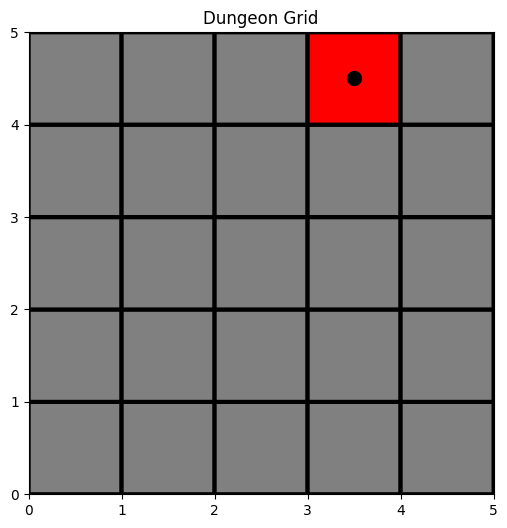

{'Description': '"(Style: High Fantasy) A grand hall adorned with intricate tapestries and gilded chandeliers. The air is filled with the scent of burning incense, and the sound of distant chanting echoes through the chamber. A marble fountain at the center of the room gushes with sparkling water, casting a soft glow on the mosaic floor."', 'NPCs': 'The unique NPC for the D&D dungeon is: Glimmer - Gnome.', 'Items': 'NONE', 'Doors': [], 'Chests': []}


In [16]:
printMap()
print(grid[currentLocation[0]][currentLocation[1]])

# Saving and Loading

In [17]:
import pickle

def save():
    with open('memory.pkl', 'wb') as file:
        pickle.dump(player, file)
        pickle.dump(grid, file)
        pickle.dump(currentLocation, file)

def load():
    with open('memory.pkl','rb') as file:
        player = pickle.load(file)
        grid = pickle.load(file)
        currentLocation = pickle.load(file)

# Main Code

In [ ]:
chat_history = []
theme = ""
def GetContext(theme:str, character:str, grid_json, currentLocation):
    return (
        f"You are a DnD Dungeon Master tasked with running a simplified DnD game. "
        f"Craft a story according to the theme: {theme}. "
        f"My character is {character}. "
        "Below is the map of their immediate surroundings and their current location. "
        "Use this map to describe the player's current room and offer options for their next move.\n\n"
        f"Current Location: {currentLocation}\n"
        f"Map Data:\n{grid_json}\n\n"
        "Steps:\n"
        "1. Describe the current room based on 'Description'.\n"
        "2. Offer options for the player's next action."
        "\n\nRules for gameplay:\n"
        "- For skill checks, the player rolls a d10.\n"
        "  - Easy scenarios require a roll of 3 or higher.\n"
        "  - Hard scenarios require a roll of 7 or higher.\n"
        "- For combat, use the attack tool to simulate turns:\n"
        "  - Player and NPC alternate attacks until one is defeated.\n"
        "  - Narrate the combat to fit the story.\n"
        "Write immersive descriptions and ensure consistency with the chosen theme and character."
    )

def PromptAndResponse(question: str, theme: str, grid_json):
    # Check if the question is a movement command
    movement_commands = ["go north", "move north", "go south", "move south", "go east", "move east", "go west", "move west"]
    movement_detected = [cmd for cmd in movement_commands if cmd in question.lower()]

    if movement_detected:
        # Extract the direction from the command
        direction = movement_detected[0].split()[-1].capitalize()
        moveRoom(direction, theme)  # Update the player's location
        # Get the new room description after moving
        new_room_desc = f"You moved {direction}. Here's what you see: {grid[currentLocation[0]][currentLocation[1]]['Description']}"
        print(new_room_desc)
        chat_history.append(HumanMessage(content=question))
        chat_history.append(AIMessage(content=new_room_desc))
    else:
        # Handle non-movement commands using the agent_executor
        response = agent_executor.invoke({
            "input": question,
            "chat_history": chat_history,
        })
        chat_history.append(HumanMessage(content=question))
        chat_history.append(AIMessage(content=response['output']))

        imageContext = agent_executor.invoke({
            "input": "Describe the surrounding in one sentence",
            "chat_history": chat_history,
        })

        print(f"Your input: {question}")
        # GenerateImage(imageContext['output'])
        print(f"Dungeon Master: {response['output']}")
        # TextToSpeech(response['output'])
    


    

Game Start

In [ ]:
# Method to play the game and enter game loop
def PlayGame(theme, grid_json):
    playing = True

    while(playing):
        question = input()
        clear_output()

        if (len(question) < 1):
            playing = False
            question = "I am done with the game. Thank you."
        PromptAndResponse(question, theme, grid_json)
    save()

# Method to get starting prompt and initialize the game
def StartGame():
    #USE TO START THE GAME PROPE
    #Create an empty map
    mapsize = 5
    grid = np.empty((mapsize, mapsize), dtype=object)
    for i in range(mapsize):
        for j in range(mapsize):
            grid[i, j] = {"Description": "Unknown", "NPCs": [], "Items": [], "Doors": [], "Chests": []}
    # Define Player Information
    player = {"Inventory":[], "Health":100, "XP":0, "Attack_Power":10}
    #Select a random starting position
    currentLocation = [random.randint(0, mapsize-1), random.randint(0, mapsize-1)]
    chat_history = []
    print("Welcome to Dungeon Intelligence. Please enter the theme of the game:")
    theme = input()
    print("Please enter your character:")
    character = input()
    player['Name'] = character
    generateRoom(theme)
    grid_json = serialize_map(grid)
    chat_history.append(AIMessage(content=GetContext(theme, character, grid_json, currentLocation)))
    #chat_history.append(AIMessage(content=currentLocation))
    print(chat_history)
    PromptAndResponse("Can you start the game with the given information?", theme, grid_json)
    PlayGame(theme, grid_json)

In [20]:
context = "TWith the given scenario, you will be designing a DnD campaign from the start."
question = "Can you begin the story?"
scenario = "Fantasy"
response = agent_executor.invoke({"input": scenario+context+question})
print(f"Response: {response['output']}")



> Entering new AgentExecutor chain...
Of course! Let's begin the story of our DnD campaign.

Title: The Quest for the Lost Relic

In the land of Eldoria, a powerful relic known as the "Crystal of Eternity" has been lost for centuries. Legends speak of its ability to grant immortality to its wielder, and many have sought to claim it for themselves. The relic is said to be hidden deep within the treacherous Darkwood Forest, guarded by ancient creatures and powerful enchantments.

As the sun sets on the horizon, a group of adventurers gathers in the bustling town of Silverhaven. Each of them bears their own reasons for seeking the Crystal of Eternity, but they share a common goal: to find the relic and harness its unimaginable power.

Our adventurers include:

1. A valiant knight, seeking to restore honor to their family name.
2. A cunning rogue, driven by the promise of untold riches.
3. A wise mage, yearning to unlock the secrets of ancient magic.
4. A fierce barbarian, thirsting for 

In [33]:
StartGame()
print(chat_history)



> Entering new AgentExecutor chain...
You're welcome! If you ever want to play again or need assistance with anything else, feel free to ask. Have a great day!

> Finished chain.


> Entering new AgentExecutor chain...
The air is thick with the scent of pine, and the sound of rustling leaves fills the tranquil forest clearing.

> Finished chain.
Your input: I am done with the game. Thank you.
Dungeon Master: You're welcome! If you ever want to play again or need assistance with anything else, feel free to ask. Have a great day!
[HumanMessage(content='Can you start the game with the given information?', additional_kwargs={}, response_metadata={}), AIMessage(content='The player has emerged victorious in the encounter, defeating the NPC with 32 health remaining. What would you like to do next?', additional_kwargs={}, response_metadata={}), HumanMessage(content='I am done with the game. Thank you.', additional_kwargs={}, response_metadata={}), AIMessage(content="You're welcome! If you ev